In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import access_spectrum as acs
import run_empca
reload(run_empca)
from run_empca import *
import polyfit as pf
silent=False
# Remember, the windows are the INVERSE of the absorption features
# Next - build ability to choose seed (both in make_specs and empca)

/usr/lib/python2.7/site-packages/setuptools-18.7.1-py2.7.egg/pkg_resources/__init__.py:1266: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
/home/price-jones/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


Populating the interactive namespace from numpy and matplotlib
/usr/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)



In [2]:
windowinfo = 'pickles/windowinfo.pkl'
elemwindows,window_all,window_peak,windowPeaks,windowPixels,tophats = acs.pklread(windowinfo)

In [3]:
specs = acs.pklread('red_clump/pickles/spectra_FE_H_u-0.4_d-0.5.pkl')[0]

In [4]:
errs = acs.pklread('red_clump/pickles/errs_FE_H_u-0.4_d-0.5.pkl')

In [5]:
def make_specs(specs,errs,elemlist,proportion=None):
    SNR = specs/errs
    vec = np.zeros(aspcappix)
    for ind in range(len(elemlist)):
        if not proportion:
            vec += elemwindows[elemlist[ind]]
        elif proportion:
            vec += elemwindows[elem[ind]]*proportion[ind]
    newspecs = np.ma.masked_array(np.tile(vec,(specs.shape[0],1)),specs.mask)
    noise = newspecs/SNR
    drawn_noise = noise*np.random.randn(noise.shape[0],noise.shape[1])
    newspecs += drawn_noise
    newspecs.mask[np.where(noise<1e-10)] = True
    noise.mask[np.where(noise<1e-10)] = True
    return newspecs,noise
def vec_weight(elem,vec):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    return np.ma.sum(nw*vec)
    
def arr_weight(elem,arr):
    w = elemwindows[elem]
    nw = np.ma.masked_array(pf.normweights(w))
    nws = np.tile(nw,(arr.shape[0],1))
    return np.ma.sum(nws*arr,axis=1)
    
def test_run(specs,noise,deltR2=2e-3,nvecs=5,mad=True,maxvec=5):
    m1,m2,w1,w2 = pix_empca(None,specs.T,noise,'test.pkl',nvecs=nvecs,deltR2=2e-3,gen=True,usemad=mad)
    R2_1 = R2(m1) #must be here (and not below resize) to avoid error
    R2_2 = R2(m2)
    R2_noise2 = R2noise(w2,m2,usemad=mad)
    resize_pix_eigvecs(specs.T,m1,nstars=5)
    resize_pix_eigvecs(specs.T,m2,nstars=5)
    m1elem = np.zeros((nvecs,len(elems)))
    m2elem = np.zeros((nvecs,len(elems)))
    specs_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    noise_weight = np.ma.masked_array(np.zeros((len(elems),specs.shape[0])))
    for ind in range(len(elems)):
        specs_weight[ind] = arr_weight(elems[ind],specs)
        noise_weight[ind] = arr_weight(elems[ind],noise)
        for vec in range(nvecs):
            m1elem[vec][ind] = vec_weight(elems[ind],m1.eigvec[vec])
            m2elem[vec][ind] = vec_weight(elems[ind],m2.eigvec[vec])
    specs_weight.mask[np.where(noise_weight<1e-10)] = True
    noise_weight.mask[np.where(noise_weight<1e-10)] = True
    m3,m4,w3,w4 = elem_empca(None,specs_weight,noise_weight,'test2.pkl',nvecs=nvecs,gen=True,deltR2=2e-3,usemad=mad)        
    R2_3 = R2(m3)
    R2_4 = R2(m4)
    R2_noise4 = R2noise(w4,m4,usemad=mad)
    resize_pix_eigvecs(specs_weight,m3,nstars=5,dim2=len(elems))
    resize_pix_eigvecs(specs_weight,m4,nstars=5,dim2=len(elems))
    for n in range(maxvec):
        plt.figure(figsize=(12,3))
        plt.axhline(0,linestyle='--',color='k',linewidth=3)
        plt.plot(norm_eigvec(m1elem[n]),'o',markersize=8,label='Pixel unweighted')
        plt.plot(norm_eigvec(m2elem[n]),'o',markersize=8,label='Pixel weighted')
        plt.plot(norm_eigvec(m3.eigvec[n]),'o',markersize=8,label='Element unweighted')
        plt.plot(norm_eigvec(m4.eigvec[n]),'o',markersize=8,label='Element weighted')
        plt.xticks(range(len(elems)),elems)
        plt.legend(loc='best',fontsize=10)
        plt.ylabel('Eigenvenctor {0}'.format(n+1))
        plt.xlim(-1,len(elems)+1)
        plt.ylim(-1,1)
    plt.figure(figsize=(12,3))
    plt.plot(R2_1,marker='o',linewidth = 3,markersize=8,label='Pixel unweighted')
    plt.plot(R2_2,marker='o',linewidth = 3,markersize=8,label='Pixel weighted')
    plt.axhline(R2_noise2,linestyle='--',color='b',linewidth=3,label='R2n_pix = {0:2f}'.format(R2_noise2))
    plt.fill_between(range(nvecs+1),R2_noise2,1,color='b',alpha=0.2)
    plt.plot(R2_3,marker='o',linewidth = 3,markersize=8,label='Element unweighted')
    plt.plot(R2_4,marker='o',linewidth = 3,markersize=8,label='Element weighted')
    plt.axhline(R2_noise4,linestyle='--',color='r',linewidth=3,label='R2n_elem = {0:2f}'.format(R2_noise4))
    plt.fill_between(range(nvecs+1),R2_noise4,1,color='r',alpha=0.2)
    plt.legend(loc='best',fontsize=10)
    
    

       iter        R2             rchi2
EMPCA  1/25      -0.00053474  23034.62054961
R2: 0.936945956249
var, Vnoise  5.36001138769e-05 4.77906716232e-06
       iter        R2             rchi2
EMPCA  1/25      -1.29226094 -923772499762375.87500000
EMPCA  2/25      -1.08405851 -11132038449789942.00000000
EMPCA  3/25      -3.62244727 -1098353385132073.37500000
EMPCA  4/25       0.72841602 -3413126520494921.50000000
EMPCA  5/25       0.71244948 -3754576297115472.00000000
EMPCA  6/25      -0.00599058 -6660053243188028.00000000
EMPCA  7/25       0.73475753 -9617070463490008.00000000
EMPCA  8/25       0.74556315 -483894434135930.62500000
EMPCA  9/25      -0.13186926 -14777481765779136.00000000
EMPCA 10/25       0.93832015 -503899397234903.06250000
EMPCA 11/25       0.99668822 -88693591775859.39062500
EMPCA 12/25       0.88810978 -233284619532218.59375000
EMPCA 13/25       0.93942794 -1005824188941549.25000000
EMPCA 14/25       0.62310453 -116586818179649.87500000
EMPCA 15/25       0.55735866

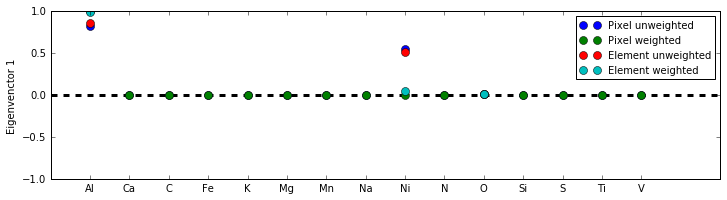

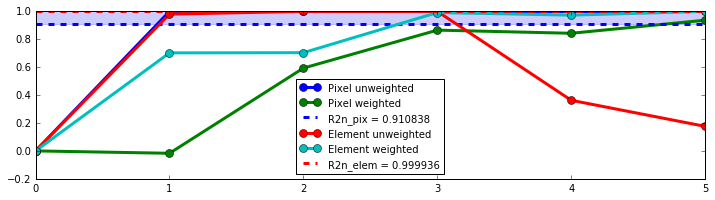

In [6]:
falsespecs,noise = make_specs(specs,errs,['Ni','Al'])
test_run(falsespecs,noise,maxvec = 1)

In [ ]:
falsespecs,noise = make_specs(specs,errs,['C','Al'])
test_run(falsespecs,noise,maxvec = 1)

In [ ]:
falsespecs,noise = make_specs(specs,errs,['C'])
test_run(falsespecs,noise,maxvec = 1)

In [ ]:
falsespecs,noise = make_specs(specs,errs,['N'])
test_run(falsespecs,noise,maxvec = 1)

In [ ]:
falsespecs,noise = make_specs(specs,errs,['O'])
test_run(falsespecs,noise,maxvec = 1)

In [ ]:
elems

In [ ]:
falsespecs,noise = make_specs(specs,errs,['C'])
test_run(falsespecs,noise,maxvec = 1)